In [23]:
"""
Having downloaded some extracted data in the previous notebook,
we now inspect our extracted data, both the flood maps and the transport network.
"""

'\nInspect our extracted data, both the flood maps and the transport network\n'

In [24]:
import os
from glob import glob

import geopandas as gpd
import rioxarray
import matplotlib.pyplot as plt
import numpy as np

from utils import aqueduct_rp

In [40]:
data_dir = "data"
country_iso = "bgd"

In [41]:
# inspect extracted network data
network_file, = glob(f"{data_dir}/{country_iso}/gri_osm*/*.gpkg")
network = gpd.read_file(network_file)
network

,asset_id,osm_way_id,asset_type,paved,material,lanes,_asset_type,rehab_cost_USD_per_km,sector,subsector,tag_bridge,bridge,wkt,geometry
0,2928776.0,55356076,rail,NaN,NaN,NaN,rail_railway,3.750000e+06,transport,rail,,False,"LINESTRING (89.8017033 24.3966571, 89.8024679 ...","LINESTRING (89.80170 24.39666, 89.80247 24.396..."
1,2928283.0,27918324,rail,NaN,NaN,NaN,rail_railway,3.750000e+06,transport,rail,,False,"LINESTRING (89.7521948 24.3984046, 89.7515152 ...","LINESTRING (89.75219 24.39840, 89.75152 24.398..."
2,2928284.0,27918324,rail,NaN,NaN,NaN,rail_railway,3.750000e+06,transport,rail,,False,"LINESTRING (89.7378159 24.39775, 89.7373877 24...","LINESTRING (89.73782 24.39775, 89.73739 24.397..."
3,2928285.0,27918348,rail,NaN,NaN,NaN,rail_railway,3.750000e+07,transport,rail,yes,True,"LINESTRING (89.7521948 24.3984046, 89.7543915 ...","LINESTRING (89.75219 24.39840, 89.75439 24.398..."
4,2928798.0,58071083,rail,NaN,NaN,NaN,rail_railway,3.750000e+06,transport,rail,,False,"LINESTRING (88.872062 23.0361493, 88.8713808 2...","LINESTRING (88.87206 23.03615, 88.87138 23.036..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38367,20453116.0,1102103635,tertiary,False,gravel,1.0,road_unpaved,2.354510e+04,transport,road,NaN,NaN,"LINESTRING (91.4312595 23.2228826, 91.4311118 ...","LINESTRING (91.43126 23.22288, 91.43111 23.222..."
38368,20452680.0,1099484696,tertiary,False,gravel,1.0,road_unpaved,2.354510e+04,transport,road,NaN,NaN,"LINESTRING (90.4754702 23.8367224, 90.4755089 ...","LINESTRING (90.47547 23.83672, 90.47551 23.83663)"
38369,20452681.0,1099484697,tertiary,False,gravel,1.0,road_unpaved,2.354510e+04,transport,road,NaN,NaN,"LINESTRING (90.4755722 23.8363913, 90.4756143 ...","LINESTRING (90.47557 23.83639, 90.47561 23.83626)"
38370,20452682.0,1099484698,tertiary,False,gravel,1.0,road_unpaved,2.354510e+04,transport,road,NaN,NaN,"LINESTRING (90.4755089 23.8366314, 90.4755722 ...","LINESTRING (90.47551 23.83663, 90.47557 23.83639)"


In [42]:
# inspect some flooding data with rasterio
return_period = 100
epoch = 2050
scenario = "rcp4p5"
flood_file, = glob(f"{data_dir}/{country_iso}/wri_aqueduct*/*inuncoast_{scenario}_wtsub_{epoch}_rp{return_period:04d}_0*.tif")
flood_map = rioxarray.open_rasterio(flood_file)
flood_map

<xarray.DataArray (band: 1, y: 706, x: 555)>
[391830 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 88.02 88.03 88.04 88.05 ... 92.61 92.62 92.63 92.64
  * y            (y) float64 26.62 26.61 26.6 26.6 ... 20.77 20.76 20.75 20.75
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999.0
    scale_factor:   1.0
    add_offset:     0.0

Text(66.97222222222221, 0.5, 'Latitude [deg]')

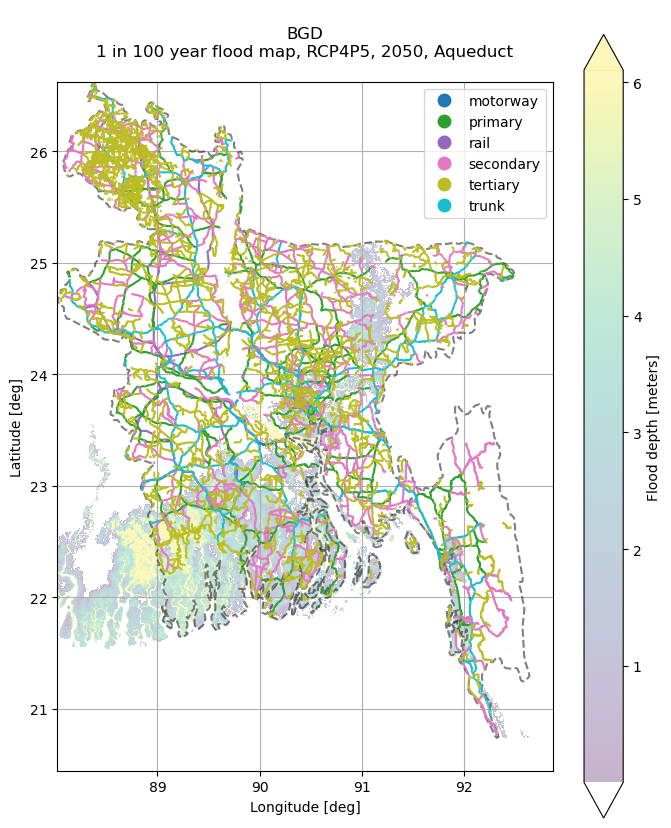

In [44]:
# plot network and flood data together

border = gpd.read_file(os.path.join(data_dir, country_iso, "territory.gpkg"))
border.geometry = border.geometry.boundary

title = f"""
{country_iso.upper()}
1 in {return_period} year flood map, {scenario.upper()}, {epoch}, Aqueduct
"""

aspect_ratio = len(flood_map.y) / len(flood_map.x)
x_in = 8
f, ax = plt.subplots(figsize=(x_in, x_in * aspect_ratio))

cmap = plt.get_cmap("viridis")
cmap.set_under("white")
img = flood_map.sel(dict(band=1)).plot.imshow(
    vmin=1E-3,
    vmax=flood_map.quantile(0.99),
    cmap=cmap,
    ax=ax,
    alpha=0.3
)
img.colorbar.ax.set_ylabel("Flood depth [meters]")

border.plot(
    ax=ax,
    alpha=0.5,
    ls="--",
    color="black"
)

network.plot(
    ax=ax,
    column="asset_type",
    legend=True,
    alpha=1
)

ax.grid()
ax.set_title(title)
ax.set_xlabel("Longitude [deg]")
ax.set_ylabel("Latitude [deg]")

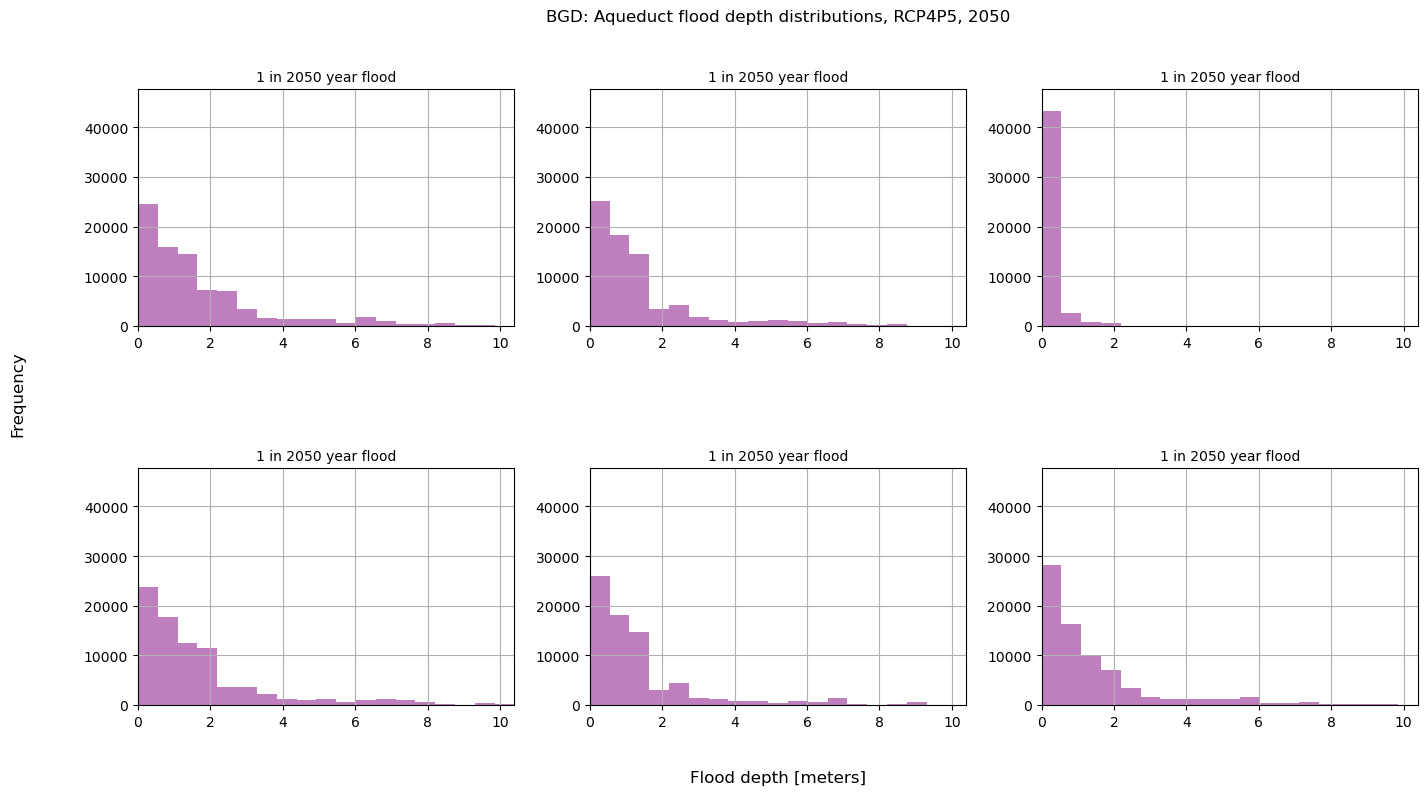

In [45]:
# plot flood depth distributions of some flood maps

epoch = 2050
scenario = "rcp4p5"
raster_paths = glob(f"data/{country_iso}/wri_aqueduct*/*{scenario}*{epoch}*.tif")
raster_paths = sorted(raster_paths, key=aqueduct_rp)

# plot a subset
raster_paths = raster_paths[-6:]

title = f"{country_iso.upper()}: Aqueduct flood depth distributions, {scenario.upper()}, {epoch}"

# find the most extreme flood value
most_extreme_map: np.ndarray = rioxarray.open_rasterio(raster_paths[-1]).squeeze().values
max_depth_all_rp: float = most_extreme_map.max()

# create a set of bins from 0 to this extreme value
bins: np.ndarray = np.linspace(0, max_depth_all_rp, 20)

# make a grid of axes to handle our (many) maps
n = len(raster_paths)
ncols = min([n, 3])
nrows = (n // ncols) + (n % ncols)
f, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 2 + 3 * nrows), squeeze=False)

# loop over rows and columns
max_count = 0
for row in range(nrows):
    for col in range(ncols):

        # bin the flood depth values and plot as histograms for each return period
        i = col + (row * ncols)
        if i < n:

            flood_map: str = raster_paths[i]
            return_period: int = aqueduct_rp(flood_map)

            ds = rioxarray.open_rasterio(flood_map)
            arr: np.ndarray = ds.squeeze().values
            arr = arr[arr > 0]

            counts, _, _ = axes[row, col].hist(arr, bins=bins, alpha=0.5, color='purple')
            axes[row, col].set_xlim(0, max_depth_all_rp)

            max_count = max([max(counts), max_count])

            axes[row, col].set_title(f"1 in {return_period} year flood", fontsize=10)
            axes[row, col].grid()

        # disable any axes we don't need
        else:
            axes[row, col].set_axis_off()

# set y-axis limits the same for all histograms
for row in range(nrows):
    for col in range(ncols):
        if col + (row * ncols) < n:
            axes[row, col].set_ylim(0, max_count * 1.1)

# label the plot
f.suptitle(title)
f.supylabel("Frequency")
f.supxlabel("Flood depth [meters]")

plt.subplots_adjust(left=0.1, hspace=0.6, wspace=0.2)